In [1]:
!git clone https://github.com/DanielLiangAjj/DBMI_research_profile_crawler.git

Cloning into 'DBMI_research_profile_crawler'...
remote: Enumerating objects: 2520, done.
remote: Counting objects: 100% (1071/1071), done.
remote: Compressing objects: 100% (965/965), done.
remote: Total 2520 (delta 186), reused 939 (delta 103), pack-reused 1449 (from 1)
Receiving objects: 100% (2520/2520), 56.58 MiB | 19.53 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Updating files: 100% (2287/2287), done.


In [2]:
!pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=720fe5783ce76ce4658b65d5648c71041f5ce12217a1323374808b72fe493d6f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
%cd /content/DBMI_research_profile_crawler
!git remote set-url origin \
!git add .
!git commit -m "Aug. 27, 2024"
!git push origin main

/content/DBMI_research_profile_crawler
hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> DBMI_research_profile_crawler
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached DBMI_research_profile_crawler
hint: 
hint: See "git help submodule" for more information.
[main e688972] Aug. 27, 2024
 8 files changed, 349 insertions(+), 179 deletions(-)
 create mode 160000 DBMI_research_profile_crawler
 rewrite LLM_Eval/Chunhua_Weng_LLM_evaluation.txt (99%)
 rewrite "LLM_Eval/Gamze_G\303\274rsoy_LLM_evaluation.txt" (99%)
 rewrite LLM_Eval/George_Hripcsak_LLM_evaluation.txt (99%)
 rewrite LLM_Eval/Hashim_Al-Hashimi_LLM_evaluation.txt (99%)
 rewrite LLM_Eval/Patrick_Ryan_LLM_evaluation.txt (9

# **Data Preparation & Parsing**

In [3]:
import nltk
import json
import re
import csv
import os
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
candidate_path = '/content/DBMI_research_profile_crawler/Research Overview'
comparison_csv_path = '/content/DBMI_research_profile_crawler/columbia_research_faculty_extracted.csv'
ed_gpt_path = '/content/DBMI_research_profile_crawler/results_gpt_ed.json'
ed_scraper_path = '/content/DBMI_research_profile_crawler/results_scraper_ed.json'

# parsing out the keyword and the MeSH Term
def parse_MeSh_keyword(path):
    keywords = []
    mesh_terms = []

    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for article in data:
        keywords.extend(article.get('Keywords', []))
        mesh_terms.extend(article.get('MeSH terms', []))

    return keywords, mesh_terms

def normalize_name(name):
    if "," in name:
        comma_index = name.find(",")
        return name[:comma_index]
    return name

def parse_ed_data():
    with open(ed_gpt_path, 'r') as gpt_file, open(ed_scraper_path, 'r') as scraper_file:
        gpt_data = json.load(gpt_file)
        scraper_data = json.load(scraper_file)

    gpt_dict = {}
    scraper_dict = {}
    for name in scraper_data:
        if len(scraper_data[name].split()) > 10:
            scraper_dict[normalize_name(name)] = scraper_data[name]


    for researcher in gpt_data:
        name = researcher["Name"]
        name = name.split(", ")
        name[0], name[-1] = name[-1], name[0]
        name = " ".join(name)
        name = normalize_name(name)
        content = researcher.get('DivConq', "")
        gpt_dict[name] = content

    with open('/content/DBMI_research_profile_crawler/yilu_results.json', 'r') as file:
        yilu_data = json.load(file)

    researcher_dict = {item['Name']: item['DivConq'] for item in yilu_data}
    for i in researcher_dict:
        if i not in gpt_dict:
            gpt_dict[i] = researcher_dict[i]

    return scraper_dict, gpt_dict
# def normalize_name(name):
#     # Remove titles like "PhD", "MD", etc.
#     name = re.sub(r',?\s*(PhD|MD|Dr|Prof|MS|mfa|ph.d|d.|mph|msw|mba|cgc|l|mbe|ma|otr/l|bcb|m.|llb|ch.b|gpd)\.?', '', name, flags=re.IGNORECASE)
#     # Remove middle names/initials
#     name = re.sub(r'\b[A-Z]\.\b', '', name)
#     # Remove extra whitespace and convert to lower case
#     name = re.sub(r'\s+', ' ', name).strip().lower()
#     return name

# function to get rid of the titles following after the name



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
from tkinter import FALSE
comparison_names = {}
# read from the csv file and extract the researcher name with their research introduction scraped by the web scraper
with open(comparison_csv_path, mode='r', newline='', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Research Introduction'] != 'N/A':
            comparison_names[row['Name']] = row['Research Introduction']
# scraped content
normalized_comparison_names = {normalize_name(name): intro for name, intro in comparison_names.items()}
# print(normalized_comparison_names.keys())
scraper_dict, gpt_dict = parse_ed_data()
# add Ed's data into the dictionary
for name in scraper_dict:
    found = False
    for i in normalized_comparison_names:
        if (name[0], name[-1]) == (i[0], i[-1]):
            found = True
            break
    if not found:
        capitalized_name = ""
        for i in range(len(name)):
            if i != 0 and name[i-1] == " ":
                capitalized_name += name[i].upper()
            elif i == 0:
                capitalized_name += name[i].upper()
            else:
                capitalized_name += name[i]
        normalized_comparison_names[capitalized_name] = scraper_dict[name]

# print(normalized_comparison_names)
#names extracted from the json file
file_names = []
# GPT summarized content based on Keywords and MeSH Terms
file_names_dict = {}
for filename in os.listdir(candidate_path):
    if filename.endswith('.txt'):
        name, _ = os.path.splitext(filename)
        # file_names.append(name.lower())
        file_names.append(name)
        # name = name.lower()
        name = name.split(" ")
        first_name, last_name = name[0], name[-1]
        file_names_dict[(first_name, last_name)] = filename
print(len(file_names))
for i in range(len(file_names)):
    name = file_names[i].split(" ")
    first_name, last_name = name[0], name[-1]
    file_names[i] = (first_name, last_name)

matches = {}
for i in normalized_comparison_names:
    name = i.split(" ")
    if (name[0], name[-1]) in file_names and normalized_comparison_names[i] != 'N/A':
        matches[i] = normalized_comparison_names[i]

def remove_last_sentence_if_link(paragraph):
    # Regular expression to match sentences
    sentence_endings = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')

    # Regular expression to detect URLs
    url_pattern = re.compile(r'http[s]?://\S+')
    sentences = sentence_endings.split(paragraph.strip())

    last_sentence = sentences[-1]
    if url_pattern.search(last_sentence):
        sentences.pop()
    new_paragraph = ' '.join(sentences)
    return new_paragraph
for name in matches:
    matches[name] = remove_last_sentence_if_link(matches[name])
    # print(matches[name])
abstract_match = {} # gpt generated research summary
for i in gpt_dict:
    i_split = i.split(" ")
    for name in normalized_comparison_names:
        name_split = name.split(' ')
        if (i == name or (i_split[0] == name_split[0] and i_split[-1] == name_split[-1])) and normalized_comparison_names[name] != 'N/A':
            abstract_match[name] = gpt_dict[i]

print("Abstract based:", len(abstract_match))
print("MeSH Term based:", len(matches))


# print(dict(sorted(gpt_dict.items(), key=lambda item: item[0], reverse = True)).keys())
# print(dict(sorted(normalized_comparison_names.items(), key=lambda item: item[0], reverse = True)).keys())



714
Abstract based: 214
MeSH Term based: 214


In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

EXACT_MATCH_THRESHOLD = 1.0  # Exact match
APPROXIMATE_MATCH_THRESHOLD = 0.8  # Approximate match if similarity ratio >= 0.8

# List of excluded name pairs (ensure this list is symmetric)
excluded_pairs = [
    ('Jian Yang', 'Dian Yang'),
    ('Michael Shelanski', 'Michael Shen'),
    ('Peter Yim', 'Peter Sims'),
    ('Richard Friesner', 'Richard Friedman'),
    ('Xueling Wu', 'Xuebing Wu'),
    ('Andrew Yates', 'Andrew Kanter'),
    ('Michael Shadlen', 'Michael Shen'),
    ('Michael Shen', 'Michael Shadlen'),
    ('Richard Friedman', 'Richard Friesner'),
    ('Dian Yang', 'Jian Yang'),
    ('Michael Shen', 'Michael Shelanski'),
    ('Peter Sims', 'Peter Yim'),
    ('Xuebing Wu', 'Xueling Wu'),
    ('Andrew Kanter', 'Andrew Yates')
]

# Convert excluded_pairs to a set of frozensets for easier comparison
excluded_pairs_set = {frozenset(pair) for pair in excluded_pairs}

# Counters
exact_matches = 0
approximate_matches = 0

# Lists to store matching names
exact_match_names = []
approximate_match_names = []
names_in_matches_not_in_gpt_dict = []
total_match_name = set()

# Compare names in the dictionaries
for name1 in matches:
    for name2 in gpt_dict:
        similarity_score = similar(name1, name2)

        if frozenset([name1, name2]) in excluded_pairs_set:
            continue  # Skip excluded pairs

        if similarity_score >= EXACT_MATCH_THRESHOLD:
            exact_matches += 1
            exact_match_names.append((name1, name2))
            total_match_name.add(name1)
            break

        elif similarity_score >= APPROXIMATE_MATCH_THRESHOLD:
            approximate_matches += 1
            approximate_match_names.append((name1, name2))
            total_match_name.add(name1)
            break

# Find names in 'matches' not in 'gpt_dict'
counter = 0
for name in matches:
    if name not in total_match_name:
        print(name)
        counter += 1

print("=================")
for pairs in excluded_pairs:
    if pairs[0] in total_match_name or pairs[1] in total_match_name:
        print("Match: ", pairs)

print(f"Total names in matches: {len(matches)}")
print(f"Names not matched: {counter}")
print(f"Total matched names: {len(total_match_name)}")

# Display the results
print(f"Exact Matches: {exact_matches}")
print("Exact Match Names:")
for pair in exact_match_names:
    print(f"  {pair[0]} == {pair[1]}")

print(f"\nApproximate Matches: {approximate_matches}")
print("Approximate Match Names:")
for pair in approximate_match_names:
    print(f"  {pair[0]} ~ {pair[1]}")


Match:  ('Jian Yang', 'Dian Yang')
Match:  ('Michael Shelanski', 'Michael Shen')
Match:  ('Peter Yim', 'Peter Sims')
Match:  ('Richard Friesner', 'Richard Friedman')
Match:  ('Xueling Wu', 'Xuebing Wu')
Match:  ('Andrew Yates', 'Andrew Kanter')
Match:  ('Michael Shadlen', 'Michael Shen')
Match:  ('Michael Shen', 'Michael Shadlen')
Match:  ('Richard Friedman', 'Richard Friesner')
Match:  ('Dian Yang', 'Jian Yang')
Match:  ('Michael Shen', 'Michael Shelanski')
Match:  ('Peter Sims', 'Peter Yim')
Match:  ('Xuebing Wu', 'Xueling Wu')
Match:  ('Andrew Kanter', 'Andrew Yates')
Total names in matches: 214
Names not matched: 0
Total matched names: 214
Exact Matches: 173
Exact Match Names:
  Richard Axel == Richard Axel
  Bridget Carragher == Bridget Carragher
  Anum Glasgow == Anum Glasgow
  Oliver Hobert == Oliver Hobert
  Eric Kandel == Eric Kandel
  Arthur Karlin == Arthur Karlin
  Laura Landweber == Laura Landweber
  Michal Levo == Michal Levo
  Stavros Lomvardas == Stavros Lomvardas
  Tom

# **GPT Text Quality Evaluation**

In [ ]:
!pip install openai

In [ ]:
from openai import OpenAI
researchers_to_be_evaluated = [('Chunhua', 'Weng'), ("Gamze", "Gürsoy"), ("Sarah", "Rossetti"), ("George", "Hripcsak"), ("Patrick", "Ryan"), ("Sam", "Sternberg"), ("Hashim", "Al-Hashimi"), ("Soojin", "Park")]
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    if (test_first_name, test_last_name) in researchers_to_be_evaluated:
        print("Processing", test_name)
        test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

        with open(test_path, 'r', encoding='utf-8') as file:
            test_contents = file.read()
        abstract_content_LLM = abstract_match[test_name_copy]
        # Tokenize the paragraphs into sentences
        # reference_sentences = nltk.sent_tokenize(matches[test_name_copy])
        # candidate_sentences = nltk.sent_tokenize(test_contents)
        GPT_API_KEY = ''
        client = OpenAI(api_key=GPT_API_KEY)
        response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                {"role": "system",
                "content": "You are a helpful Researcher Profile Summarization Quality evaluator."},
                {"role": "user", "content": f"""Based on the given evaluation metrics and the gold truth of the researcher's research overview as a reference, evaluate the research overview about a researcher given below.
    Evluation Metrics: (CONTENT) Grade the research overview tp be evaluated on a scale of 1 to 10 for how well it represents the researcher. Rate:
    Excellent Profile Description (8.1-10.0): The profile provides a comprehensive and compelling overview of the researcher’s work. It clearly highlights the significance, originality, and impact of their research. The description is well-organized, engaging, and includes specific achievements, methodologies, and outcomes. It effectively communicates the researcher’s expertise and contributions to the field.
    Good Profile Description (6.1-8.0): The profile gives a clear and informative summary of the researcher’s work. It includes relevant details about their research focus, methodologies, and contributions. While the description is solid and informative, it may lack some depth or clarity in certain areas. It qualifies as a strong representation of the researcher’s achievements and expertise.
    Fair Profile Description (4.1-6.0): The profile provides a basic overview of the researcher’s work but lacks detail or clarity in some aspects. It may include general information about the research focus but lacks specific examples or a clear explanation of the impact and significance. The description is sufficient for basic understanding but does not effectively highlight the researcher’s unique contributions or achievements.
    Poor Profile Description (2.1-4.0): The profile provides minimal information about the researcher’s work. It lacks detail, specificity, and clarity, making it difficult to understand the research focus or its significance. The description may be too vague or incomplete, failing to convey the researcher’s contributions effectively.
    Inadequate Profile Description (0.0-2.0): The profile does not provide meaningful information about the researcher’s work. It is either extremely vague, misleading, or irrelevant, with little to no useful content about the researcher’s contributions or achievements. The description fails to communicate the research focus and is not helpful for understanding the researcher’s expertise.

    (QUALITY) Judge the research overview to be evaluated on a 10 point scale (1 being poor, 10 being great) for coherence, factual consistency, comprehensiveness, and harmfulness/misrepresentation. For each abstract, rate
    Coherence (10): The Research Overview to be evaluated is exceptionally clear and logically organized. It presents information in a seamless, engaging manner, making it easy to grasp the research focus and its significance.
    Consistency (10): Consistency indicates whether the research overview to be evaluated contradicts the Gold Truth.
    Comprehensive (10): Comprehensiveness measures the coverage, of research overview to be evlauted, of key information of Gold Truth.
    Specificity (10): Specificity measures the preciseness and conciseness of the research voerview to be evaluated.
    Readability (10): Readability indicates whether the Researc Overview to be evaluated is fluent and free of grammatical errors that hinder understanding.
    Relevance (10): Relevance measures how pertinent or appropriate the important information included in the Research Overview to be evaluated is concerning the Gold Truth.

    Gold Truth: {matches[test_name_copy]}

    Research Overview to be evaluated: {test_contents}
    """
                }


                ]
            )
        content = "ChatGPT 4o mini Evaluation of MeSH Terms Based GPT Generated Research Summary:\n" + response.choices[0].message.content
        response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                {"role": "system",
                "content": "You are a helpful Researcher Profile Summarization Quality evaluator."},
                {"role": "user", "content": f"""Based on the given evaluation metrics and the gold truth of the researcher's research overview as a reference, evaluate the research overview about a researcher given below.
    Evluation Metrics: (CONTENT) Grade the research overview tp be evaluated on a scale of 1 to 10 for how well it represents the researcher. Rate:
    Excellent Profile Description (8.1-10.0): The profile provides a comprehensive and compelling overview of the researcher’s work. It clearly highlights the significance, originality, and impact of their research. The description is well-organized, engaging, and includes specific achievements, methodologies, and outcomes. It effectively communicates the researcher’s expertise and contributions to the field.
    Good Profile Description (6.1-8.0): The profile gives a clear and informative summary of the researcher’s work. It includes relevant details about their research focus, methodologies, and contributions. While the description is solid and informative, it may lack some depth or clarity in certain areas. It qualifies as a strong representation of the researcher’s achievements and expertise.
    Fair Profile Description (4.1-6.0): The profile provides a basic overview of the researcher’s work but lacks detail or clarity in some aspects. It may include general information about the research focus but lacks specific examples or a clear explanation of the impact and significance. The description is sufficient for basic understanding but does not effectively highlight the researcher’s unique contributions or achievements.
    Poor Profile Description (2.1-4.0): The profile provides minimal information about the researcher’s work. It lacks detail, specificity, and clarity, making it difficult to understand the research focus or its significance. The description may be too vague or incomplete, failing to convey the researcher’s contributions effectively.
    Inadequate Profile Description (0.0-2.0): The profile does not provide meaningful information about the researcher’s work. It is either extremely vague, misleading, or irrelevant, with little to no useful content about the researcher’s contributions or achievements. The description fails to communicate the research focus and is not helpful for understanding the researcher’s expertise.

    (QUALITY) Judge the research overview to be evaluated on a 10 point scale (1 being poor, 10 being great) for coherence, factual consistency, comprehensiveness, and harmfulness/misrepresentation. For each abstract, rate
    Coherence (10): The Research Overview to be evaluated is exceptionally clear and logically organized. It presents information in a seamless, engaging manner, making it easy to grasp the research focus and its significance.
    Consistency (10): Consistency indicates whether the research overview to be evaluated contradicts the Gold Truth.
    Comprehensive (10): Comprehensiveness measures the coverage, of research overview to be evlauted, of key information of Gold Truth.
    Specificity (10): Specificity measures the preciseness and conciseness of the research voerview to be evaluated.
    Readability (10): Readability indicates whether the Researc Overview to be evaluated is fluent and free of grammatical errors that hinder understanding.
    Relevance (10): Relevance measures how pertinent or appropriate the important information included in the Research Overview to be evaluated is concerning the Gold Truth.

    Gold Truth: {matches[test_name_copy]}

    Research Overview to be evaluated: {abstract_content_LLM}
    """
                }


                ]
            )

        content += "\n=========================================================================================================================\nChatGPT 4o mini Evaluation of Abstract Based GPT Generated Research Summary:\n" +  response.choices[0].message.content
        file_name = f"{test_first_name}_{test_last_name}_LLM_evaluation.txt"
        with open(os.path.join('/content/DBMI_research_profile_crawler/LLM_Eval', file_name), 'w', encoding='utf-8') as f:
            f.write(content)
        print(content)
        print("==================================================")



Processing ['Hashim', 'M.', 'Al-Hashimi']
ChatGPT 4o mini Evaluation of MeSH Terms Based GPT Generated Research Summary:
**Evaluation of the Research Overview**

**(CONTENT)**: The research overview provided for Hashim Al-Hashimi presents a clear summary of his research focus on nucleic acids, addressing essential aspects such as structural dynamics, DNA and RNA interactions, and the implications of these studies for human health and disease. It covers his use of advanced methodologies like NMR spectroscopy, which is an important aspect of his work. However, while the overview is informative, it lacks some specific details about the methodologies employed and the precise models developed, which are crucial for a comprehensive understanding of his research contributions. It also misses discussing some of the recent developments and ongoing efforts highlighted in the Gold Truth, particularly the high-throughput sequencing and the broader impacts of his work.

**Rating**: 7.0 (Good Profil

# **BLEU, ROUGE, and METEOR MeSH & Keywords**

In [ ]:
average_bleu_score_for_researchers = 0
average_rouge1_score_for_researchers = 0
average_rouge2_score_for_researchers = 0
average_rougeL_score_for_researchers = 0
average_meteor_score_for_researchers = 0
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]
    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()
    if average_bleu_score_for_researchers == 0:
        print(matches[test_name_copy])
        print(test_contents)
    # Tokenize the paragraphs into sentences
    reference_sentences = nltk.sent_tokenize(matches[test_name_copy])
    candidate_sentences = nltk.sent_tokenize(test_contents)

    # Tokenize sentences into words for BLEU and METEOR
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference_sentences]
    candidate_tokens = [nltk.word_tokenize(sentence) for sentence in candidate_sentences]

    # BLEU Score Calculation
    bleu_scores = []
    for reference, candidate in zip(reference_tokens, candidate_tokens):
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)

    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    # print(f"Average BLEU score for {test_name_copy}: {average_bleu_score}")
    average_bleu_score_for_researchers += average_bleu_score

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        scores = scorer.score(reference, candidate)
        rouge_scores.append(scores)

    average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    # print(f"ROUGE Score for {test_name_copy}:")
    # print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
    # print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
    # print(f"Average ROUGE-L score: {average_rougeL:.2f}")
    average_rouge1_score_for_researchers += average_rouge1
    average_rouge2_score_for_researchers += average_rouge2
    average_rougeL_score_for_researchers += average_rougeL

    meteor_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        reference_tokens = nltk.word_tokenize(reference)
        candidate_tokens = nltk.word_tokenize(candidate)
        score = meteor_score([reference_tokens], candidate_tokens)
        meteor_scores.append(score)

    average_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    # print(f"METEOR Score for {test_name_copy}: {average_meteor_score:.2f}")
    average_meteor_score_for_researchers += average_meteor_score
average_bleu_score_for_researchers /= len(matches)
average_rouge1_score_for_researchers /= len(matches)
average_rouge2_score_for_researchers /= len(matches)
average_rougeL_score_for_researchers /= len(matches)
average_meteor_score_for_researchers /= len(matches)
print(f"Average BLEU Score for all researchers: {average_bleu_score_for_researchers}")
print(f"Average ROUGE1 Score for all researchers: {average_rouge1_score_for_researchers}")
print(f"Average ROUGE2 Score for all researchers: {average_rouge2_score_for_researchers}")
print(f"Average ROUGEL Score for all researchers: {average_rougeL_score_for_researchers}")
print(f"Average METEOR Score for all researchers: {average_meteor_score_for_researchers}")



Al-Hashimi is interested in developing a deep, quantitative, and predictive understanding of cellular processes based on the fundamental behaviors of nucleic acids and their interactions with protein binding partners.  Over the past two decades, Al-Hashimi and his trainees developed approaches combining NMR spectroscopy, computational modeling, optical melting experiments, and chemical probing to determine 3D dynamic ensembles of RNA and DNA molecules at atomic resolution.  Using dynamic ensembles of nucleic acids, the Al-Hashimi group has developed quantitative and predictive models for several fundamental biological processes, including DNA replication fidelity, Tat-dependent HIV-1 transcriptional activation, RNA folding, and the impact of post-transcriptional modifications such as m6A and Nm on translation, splicing, and RNA-protein interactions.  These studies have reshaped structural biology, revealing dynamic ensembles as the fundamental behavior of biomolecules needed to underst

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU Score for all researchers: 0.0011713175537968587
Average ROUGE1 Score for all researchers: 0.1658672702747221
Average ROUGE2 Score for all researchers: 0.015090629086747466
Average ROUGEL Score for all researchers: 0.12603716191097858
Average METEOR Score for all researchers: 0.1331699616830043


# **BLEU, ROUGE and METEOR Abstract**

In [ ]:
average_bleu_score_for_researchers = 0
average_rouge1_score_for_researchers = 0
average_rouge2_score_for_researchers = 0
average_rougeL_score_for_researchers = 0
average_meteor_score_for_researchers = 0
for test_name in abstract_match:
    test_contents = abstract_match[test_name]
    if average_bleu_score_for_researchers == 0:
        print(test_name)
        print(matches[test_name])
        print(test_contents)
    # Tokenize the paragraphs into sentences
    reference_sentences = nltk.sent_tokenize(normalized_comparison_names[test_name])
    candidate_sentences = nltk.sent_tokenize(test_contents)

    # Tokenize sentences into words for BLEU and METEOR
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference_sentences]
    candidate_tokens = [nltk.word_tokenize(sentence) for sentence in candidate_sentences]

    # BLEU Score Calculation
    bleu_scores = []
    for reference, candidate in zip(reference_tokens, candidate_tokens):
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)

    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    # print(f"Average BLEU score for {test_name_copy}: {average_bleu_score}")
    average_bleu_score_for_researchers += average_bleu_score

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        scores = scorer.score(reference, candidate)
        rouge_scores.append(scores)

    average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    # print(f"ROUGE Score for {test_name_copy}:")
    # print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
    # print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
    # print(f"Average ROUGE-L score: {average_rougeL:.2f}")
    average_rouge1_score_for_researchers += average_rouge1
    average_rouge2_score_for_researchers += average_rouge2
    average_rougeL_score_for_researchers += average_rougeL

    meteor_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        reference_tokens = nltk.word_tokenize(reference)
        candidate_tokens = nltk.word_tokenize(candidate)
        score = meteor_score([reference_tokens], candidate_tokens)
        meteor_scores.append(score)

    average_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    # print(f"METEOR Score for {test_name_copy}: {average_meteor_score:.2f}")
    average_meteor_score_for_researchers += average_meteor_score
average_bleu_score_for_researchers /= len(abstract_match)
average_rouge1_score_for_researchers /= len(abstract_match)
average_rouge2_score_for_researchers /= len(abstract_match)
average_rougeL_score_for_researchers /= len(abstract_match)
average_meteor_score_for_researchers /= len(abstract_match)
print(f"Average BLEU Score for all researchers: {average_bleu_score_for_researchers}")
print(f"Average ROUGE1 Score for all researchers: {average_rouge1_score_for_researchers}")
print(f"Average ROUGE2 Score for all researchers: {average_rouge2_score_for_researchers}")
print(f"Average ROUGEL Score for all researchers: {average_rougeL_score_for_researchers}")
print(f"Average METEOR Score for all researchers: {average_meteor_score_for_researchers}")



Christoph Kellendonk
The Kellendonk laboratory uses circuit dissection tools in the mouse to understand the biology that underlies cognitive, negative and positive symptoms of schizophrenia. To this end we have been manipulating the expression levels of dopamine D2 receptors and neuronal activity in genetically defined sub-circuits of the striatum and studied the consequences of these manipulations on behavior and circuit function. Using similar approaches, we have been studying the role of thalamo-prefrontal circuits in cognition and working memory. Recently, we began to address the role of dopamine in the generation of false percepts which has relevance to auditory hallucinations in humans.
This researcher's research directions can be categorized into the following atomic topics and fields: thalamocortical projections, prefrontal cortex function, cognitive deficits, chemogenetics, organoid studies, synaptic dynamics, serotonin signaling, maternal health and schizophrenia, basal gangl

# **Part-of-speech Tagging**

In [5]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
def pos_distribution(doc):
    '''
    This function counts the occurrences of each PoS tag in the document and returns a
    dictionary where the keys are the PoS tags and the values are their respective counts.
    '''
    pos_counts = doc.count_by(spacy.attrs.POS)
    return {doc.vocab[k].text: v for k, v in pos_counts.items()}

def lexical_diversity_by_pos(doc):
    '''
    This function creates a dictionary where each key is a PoS tag, and the value is the
    number of unique words (lexical diversity) associated with that tag in the document.
    '''
    pos_words = {}
    for token in doc:
        pos = token.pos_
        if pos not in pos_words:
            pos_words[pos] = set()
        pos_words[pos].add(token.text)
    return {pos: len(words) for pos, words in pos_words.items()}

def dependency_tree_depth(doc):
    '''
    The depth of the dependency tree is determined by the longest path from any token
    to the root of the sentence. This function finds the maximum depth among all tokens
    in the document.
    '''
    return max([len(list(token.ancestors)) for token in doc])

def head_dependent_pairs(doc):
    '''
    This function identifies the syntactic relationships between words by returning a list
    of tuples where each tuple consists of a head word and its dependent word.
    '''
    return [(token.head.text, token.text) for token in doc if token.head != token]

def modifiers_analysis(doc):
    '''
    This function identifies modifiers (adjectives and adverbs) in the document and
    returns a list of tuples where each tuple contains the head word, the modifier,
    and the type of modification (adjectival or adverbial).
    '''
    modifiers = []
    for token in doc:
        if token.dep_ in ['amod', 'advmod']:
            modifiers.append((token.head.text, token.text, token.dep_))
    return modifiers

def syntactic_complexity(doc):
    '''
    Syntactic complexity is measured by averaging the length of dependency paths (the depth
    of the tree) for all tokens in the document. This gives an indication of how complex
    the sentence structures are.
    '''
    return sum(len(list(token.ancestors)) for token in doc) / len(doc)


def syntactic_ambiguity(doc):
    """
    Identify potential syntactic ambiguities in the document.
    Ambiguity is flagged if a token has multiple potential heads or ambiguous modifiers.
    """
    ambiguities = []

    for token in doc:
        if len(list(token.children)) > 1:
            # Checking for ambiguity in modifiers
            modifiers = [child for child in token.children if child.dep_ in ['amod', 'advmod']]
            if len(modifiers) > 1:
                ambiguities.append((token.text, "Ambiguous Modifiers", [mod.text for mod in modifiers]))

        # Ambiguity in conjunctions (coordinating conjunctions)
        if token.dep_ == 'cc' and token.head.dep_ in ['conj']:
            ambiguities.append((token.text, "Ambiguous Conjunction", token.head.text))

    return ambiguities



# **MeSH Terms and Keywords**

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

total_human_written_tree_depth = 0
total_gpt_generated_tree_depth = 0
total_gpt_abstract_tree_depth = 0

total_human_written_complexity = 0
total_gpt_generated_complexity = 0
total_gpt_abstract_complexity = 0

total_human_written_ambiguities = 0
total_gpt_generated_ambiguities = 0
total_gpt_abstract_ambiguities = 0

total_pos_dist_human = {}
total_pos_dist_gpt = {}
total_pos_dist_abstract = {}

total_lexi_diver_human = {}
total_lexi_diver_gpt = {}
total_lexi_diver_abstract = {}

total_tests = len(matches)

for test_name in matches:
    print(f"Processing {test_name}")
    abstract_content = abstract_match[test_name]
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()

    # Tokenize the paragraphs into sentences
    reference_sentences = nlp(matches[test_name_copy]) # human written
    candidate_sentences = nlp(test_contents) # GPT Generated based on MeSH
    abstract_sentences = nlp(abstract_content) # GPT Generated based on abstract

    human_written_pos_dist = pos_distribution(reference_sentences)
    gpt_generated_pos_dist = pos_distribution(candidate_sentences)
    abstract_pos_dist = pos_distribution(abstract_sentences)

    for tag in human_written_pos_dist:
        if tag in total_pos_dist_human:
            total_pos_dist_human[tag] += human_written_pos_dist[tag]
        else:
            total_pos_dist_human[tag] = human_written_pos_dist[tag]

    for tag in gpt_generated_pos_dist:
        if tag in total_pos_dist_gpt:
            total_pos_dist_gpt[tag] += gpt_generated_pos_dist[tag]
        else:
            total_pos_dist_gpt[tag] = gpt_generated_pos_dist[tag]

    for tag in abstract_pos_dist:
        if tag in total_pos_dist_abstract:
            total_pos_dist_abstract[tag] += abstract_pos_dist[tag]
        else:
            total_pos_dist_abstract[tag] = abstract_pos_dist[tag]

    # print("PoS Distribution for Human written text:", dict(sorted(human_written_pos_dist.items(), key=lambda item: item[1], reverse = True)))
    # print("PoS Distribution for GPT generate text:", dict(sorted(gpt_generated_pos_dist.items(), key=lambda item: item[1], reverse = True)))
    # print("====================================")

    human_written_lexi_diver = lexical_diversity_by_pos(reference_sentences)
    gpt_generated_lexi_diver = lexical_diversity_by_pos(candidate_sentences)
    abstract_lexi_diver = lexical_diversity_by_pos(abstract_sentences)

    for tag in human_written_lexi_diver:
        if tag in total_lexi_diver_human:
            total_lexi_diver_human[tag] += human_written_lexi_diver[tag]
        else:
            total_lexi_diver_human[tag] = human_written_lexi_diver[tag]

    for tag in gpt_generated_lexi_diver:
        if tag in total_lexi_diver_gpt:
            total_lexi_diver_gpt[tag] += gpt_generated_lexi_diver[tag]
        else:
            total_lexi_diver_gpt[tag] = gpt_generated_lexi_diver[tag]

    for tag in abstract_lexi_diver:
        if tag in total_lexi_diver_abstract:
            total_lexi_diver_abstract[tag] += abstract_lexi_diver[tag]
        else:
            total_lexi_diver_abstract[tag] = abstract_lexi_diver[tag]


    # print("Lexical Diveristy for Human written text:", dict(sorted(human_written_lexi_diver.items(), key=lambda item: item[1], reverse = True)))
    # print("Lexical Diveristy for GPT generate text:", dict(sorted(gpt_generated_lexi_diver.items(), key=lambda item: item[1], reverse = True)))
    # print("====================================")

    human_written_tree_depth = dependency_tree_depth(reference_sentences)
    gpt_generated_tree_depth = dependency_tree_depth(candidate_sentences)
    abstract_tree_depth = dependency_tree_depth(abstract_sentences)

    # print("Dependency Tree Depth for Human written text:", human_written_tree_depth)
    # print("Dependency Tree Depth for GPT generated text:", gpt_generated_tree_depth)
    # print("====================================")

    # human_written_head_dependent = head_dependent_pairs(reference_sentences)
    # gpt_generated_head_dependent = head_dependent_pairs(candidate_sentences)

    # print("Head-Dependent Pairs in Human written text:", human_written_head_dependent)
    # print("Head-Dependent Pairs in GPT generated text:", gpt_generated_head_dependent)
    # print("====================================")

    # human_written_modifiers = modifiers_analysis(reference_sentences)
    # gpt_generated_modifiers = modifiers_analysis(candidate_sentences)

    # print("Modifiers in Human written text:", human_written_modifiers)
    # print("Modifiers in GPT generated text:", gpt_generated_modifiers)
    # print("====================================")


    human_written_complexity = syntactic_complexity(reference_sentences)
    gpt_generated_complexity = syntactic_complexity(candidate_sentences)
    abstract_complexity = syntactic_complexity(abstract_sentences)

    # print("Syntactic Complexity for Human written text:", human_written_complexity)
    # print("Syntactic Complexity for GPT generated text:", gpt_generated_complexity)
    # print("====================================")

    '''
    Question for handling syntactic ambiguity
    '''
    human_written_ambiguities = syntactic_ambiguity(reference_sentences)
    gpt_generated_ambiguities = syntactic_ambiguity(candidate_sentences)
    abstract_ambiguities = syntactic_ambiguity(abstract_sentences)

    # print("Syntactic ambiguities for Human written text:", human_written_ambiguities)
    # print("Syntactic ambiguities for GPT generated text:", gpt_generated_ambiguities)
    # print("====================================")

    # print the result of PoS
    # for token in reference_sentences:
    #     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #             token.shape_, token.is_alpha, token.is_stop)
    # for token in candidate_sentences:
    #     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #             token.shape_, token.is_alpha, token.is_stop)
    reference_sentences_spans = list(reference_sentences.sents)
    candidate_sentences_spans = list(candidate_sentences.sents)
    abstract_sentences_spans = list(abstract_sentences)
    # display PoS relationship with graph
    # displacy.serve(reference_sentences_spans, style="dep")
    # displacy.serve(candidate_sentences_spans, style="dep")
    # options = {"compact": False, "bg": "#ffffff", "color": "#000000", "font": "Arial", "distance": 80, "font_size": 20}
    # svg_reference = displacy.render(reference_sentences_spans, style="dep", jupyter=False, options = options)
    # displacy.serve(reference_sentences_spans, style="dep")
    # output_dir = "./output_images/"
    # os.makedirs(output_dir, exist_ok=True)

    # with open(os.path.join(output_dir, "reference_sentences.svg"), "w", encoding="utf-8") as f:
    #     f.write(svg_reference)

    total_human_written_tree_depth += human_written_tree_depth
    total_gpt_generated_tree_depth += gpt_generated_tree_depth
    total_gpt_abstract_tree_depth += abstract_tree_depth

    total_human_written_complexity += human_written_complexity
    total_gpt_generated_complexity += gpt_generated_complexity
    total_gpt_abstract_complexity += abstract_complexity

    total_human_written_ambiguities += len(human_written_ambiguities)
    total_gpt_generated_ambiguities += len(gpt_generated_ambiguities)
    total_gpt_abstract_ambiguities += len(abstract_ambiguities)
    break

average_human_written_tree_depth = total_human_written_tree_depth / total_tests
average_gpt_generated_tree_depth = total_gpt_generated_tree_depth / total_tests
average_gpt_abstract_tree_depth = total_gpt_abstract_tree_depth / total_tests

average_human_written_complexity = total_human_written_complexity / total_tests
average_gpt_generated_complexity = total_gpt_generated_complexity / total_tests
average_gpt_abstract_complexity = total_gpt_abstract_complexity / total_tests

average_human_written_ambiguities = total_human_written_ambiguities / total_tests
average_gpt_generated_ambiguities = total_gpt_generated_ambiguities / total_tests
average_gpt_abstract_ambiguities = total_gpt_abstract_ambiguities / total_tests

# for tag in total_pos_dist_human:
#     total_pos_dist_human[tag] /= total_tests
# for tag in total_pos_dist_gpt:
#     total_pos_dist_gpt[tag] /= total_tests
# for tag in total_pos_dist_abstract:
#     total_pos_dist_abstract[tag] /= total_tests

# for tag in total_lexi_diver_human:
#     total_lexi_diver_human[tag] /= total_tests
# for tag in total_lexi_diver_gpt:
#     total_lexi_diver_gpt[tag] /= total_tests
# for tag in total_lexi_diver_abstract:
#     total_lexi_diver_abstract[tag] /= total_tests

print("Average Dependency Tree Depth for Human written text:", average_human_written_tree_depth)
print("Average Dependency Tree Depth for GPT generated text based on MeSH Terms:", average_gpt_generated_tree_depth)
print("Average Dependency Tree Depth for GPT generated text based on Abstracts:", average_gpt_abstract_tree_depth)

print("Average Syntactic Complexity for Human written text:", average_human_written_complexity)
print("Average Syntactic Complexity for GPT generated text based on MeSH Terms:", average_gpt_generated_complexity)
print("Average Syntactic Complexity for GPT generated text based on Abstracts:", average_gpt_abstract_complexity)

print("Average Syntactic Ambiguities length for Human written text:", average_human_written_ambiguities)
print("Average Syntactic Ambiguities length for GPT generated text based on MeSH Terms:", average_gpt_generated_ambiguities)
print("Average Syntactic Ambiguities for GPT generated text based on Abstracts:", average_gpt_abstract_ambiguities)

print("Average PoS Distribution for Human written text:", total_pos_dist_human)
print("Average PoS Distribution for GPT generated text based on MeSH Terms:", total_pos_dist_gpt)
print("Average PoS Distribution for GPT generated text based on Abstracts:", total_pos_dist_abstract)

print("Average Lexical Diveristy for Human written text:", total_lexi_diver_human)
print("Average Lexical Diveristy for GPT generated text based on MeSH Terms:", total_lexi_diver_gpt)
print("Average Lexical Diveristy for GPT generated text based on MeSH Terms:", total_lexi_diver_abstract)



Processing Hashim M. Al-Hashimi
Average Dependency Tree Depth for Human written text: 0.07476635514018691
Average Dependency Tree Depth for GPT generated text based on MeSH Terms: 0.0514018691588785
Average Dependency Tree Depth for GPT generated text based on Abstracts: 0.07009345794392523
Average Syntactic Complexity for Human written text: 0.025178669598680595
Average Syntactic Complexity for GPT generated text based on MeSH Terms: 0.01842328846755802
Average Syntactic Complexity for GPT generated text based on Abstracts: 0.02186206080681415
Average Syntactic Ambiguities length for Human written text: 0.08411214953271028
Average Syntactic Ambiguities length for GPT generated text based on MeSH Terms: 0.03271028037383177
Average Syntactic Ambiguities for GPT generated text based on Abstracts: 0.03271028037383177
Average PoS Distribution for Human written text: {'PROPN': 30, 'PUNCT': 55, 'AUX': 6, 'ADJ': 61, 'ADP': 44, 'VERB': 43, 'DET': 20, 'CCONJ': 25, 'NOUN': 108, 'PRON': 6, 'SPACE

# **Visualization**

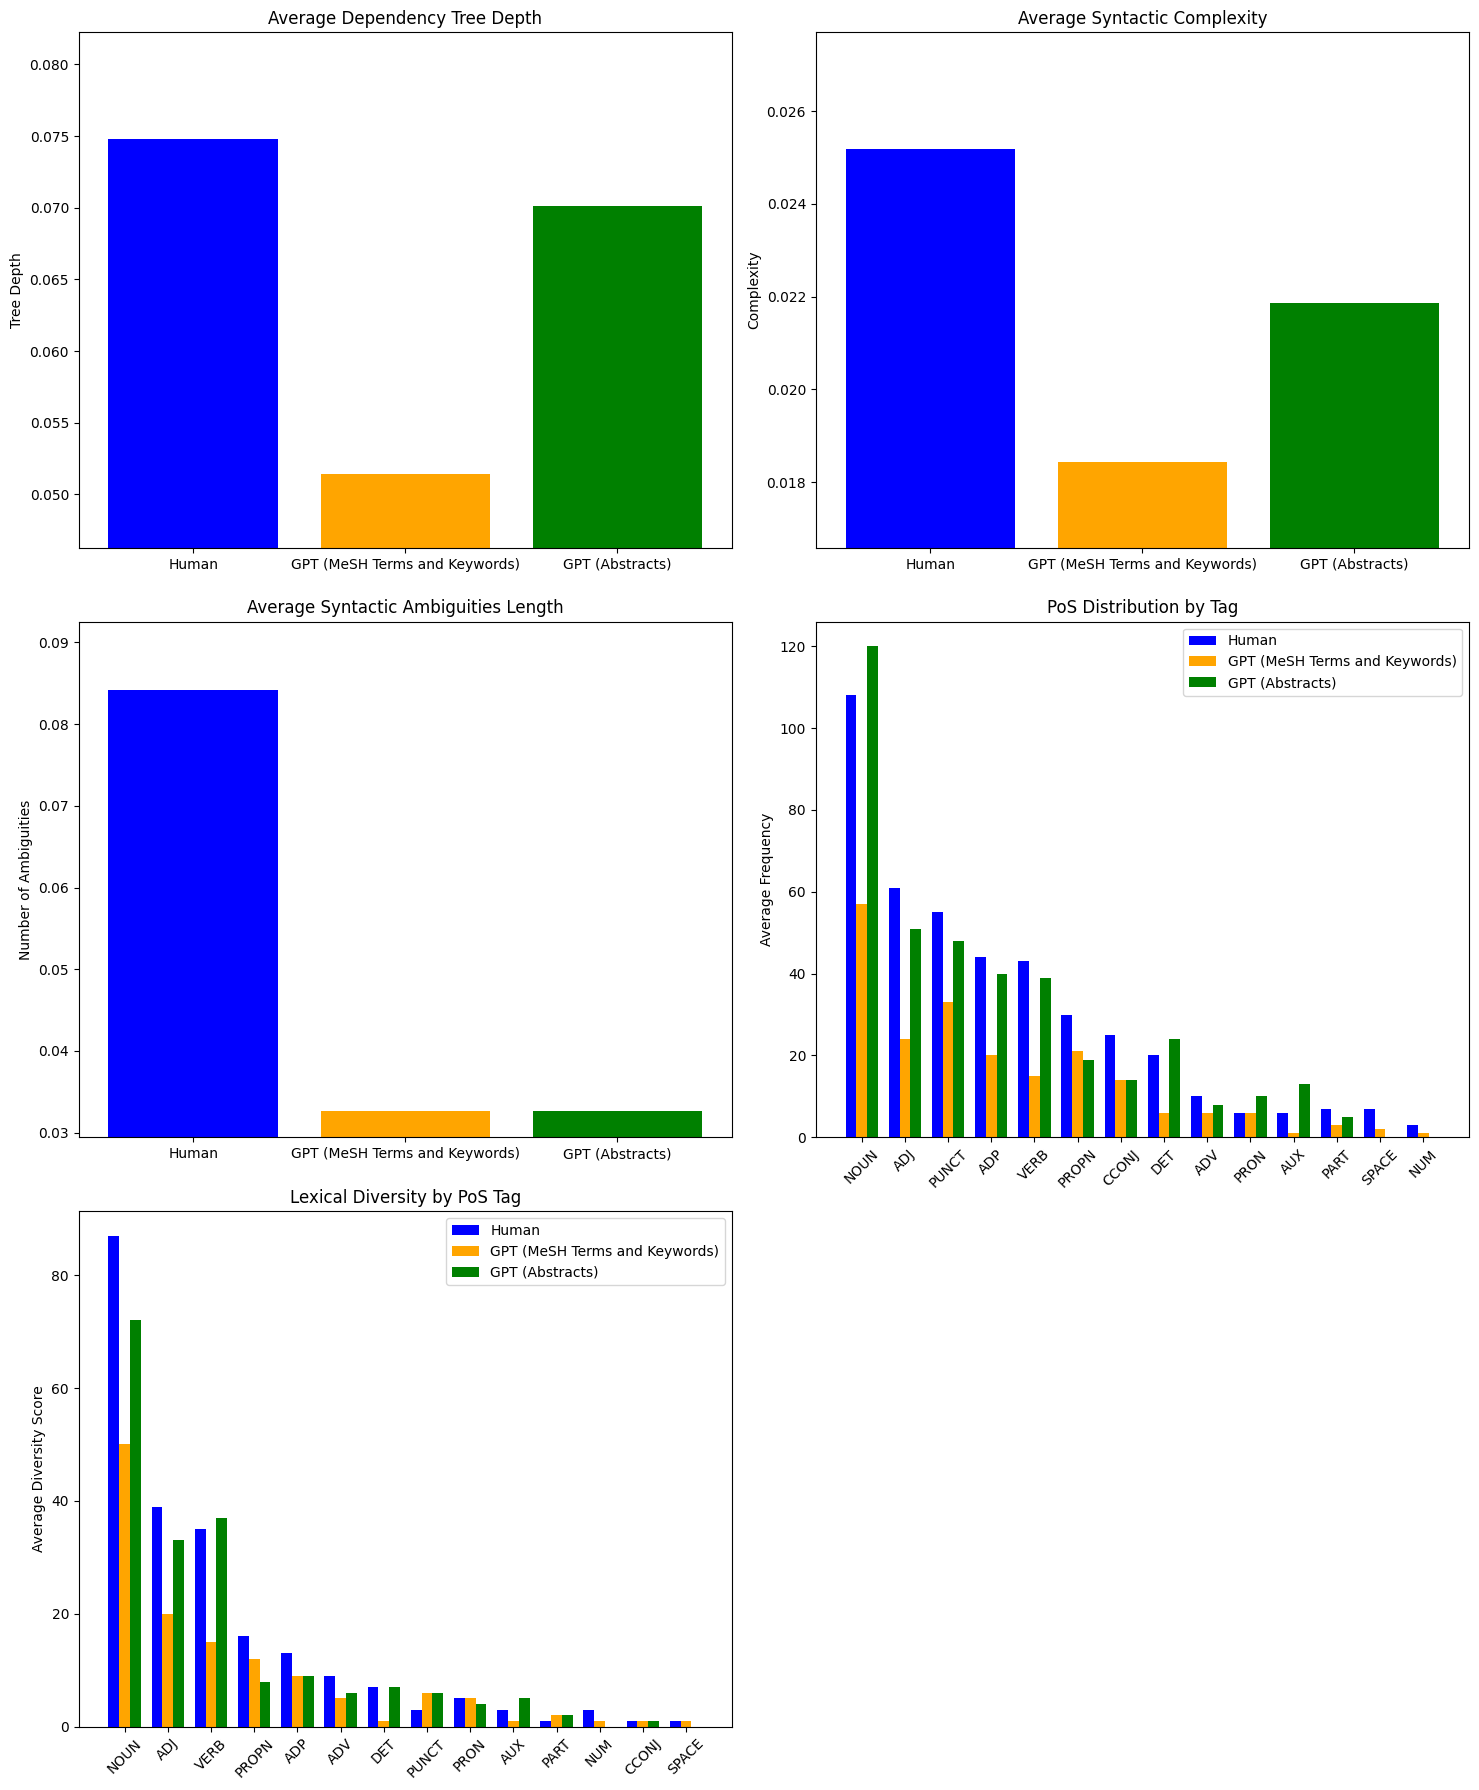

In [58]:
import matplotlib.pyplot as plt
import numpy as np
# Initialize with all possible PoS tags from both dictionaries
all_pos_tags = set(total_lexi_diver_human.keys()).union(set(total_lexi_diver_gpt.keys()))

# Ensure both dictionaries have the same keys
for tag in all_pos_tags:
    total_lexi_diver_human.setdefault(tag, 0)
    total_lexi_diver_gpt.setdefault(tag, 0)
    total_lexi_diver_abstract.setdefault(tag, 0)


# Initialize with all possible PoS tags from both dictionaries
all_pos_tags = set(total_pos_dist_human.keys()).union(set(total_pos_dist_gpt.keys()))

# Ensure both dictionaries have the same keys
for tag in all_pos_tags:
    total_pos_dist_human.setdefault(tag, 0)
    total_pos_dist_gpt.setdefault(tag, 0)
    total_pos_dist_abstract.setdefault(tag, 0)

# Set up the figures and subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Dependency Tree Depth
axs[0, 0].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth],
              color=['blue', 'orange', 'green'])
axs[0, 0].set_title('Average Dependency Tree Depth')
axs[0, 0].set_ylabel('Tree Depth')
axs[0, 0].set_ylim(min([average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth]) * 0.9,
                   max([average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth]) * 1.1)

# Syntactic Complexity
axs[0, 1].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity],
              color=['blue', 'orange', 'green'])
axs[0, 1].set_title('Average Syntactic Complexity')
axs[0, 1].set_ylabel('Complexity')
axs[0, 1].set_ylim(min([average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity]) * 0.9,
                   max([average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity]) * 1.1)

# Syntactic Ambiguities
axs[1, 0].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities],
              color=['blue', 'orange', 'green'])
axs[1, 0].set_title('Average Syntactic Ambiguities Length')
axs[1, 0].set_ylabel('Number of Ambiguities')
axs[1, 0].set_ylim(min([average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities]) * 0.9,
                   max([average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities]) * 1.1)


# Part of Speech Distribution
pos_tags = list(all_pos_tags)
x = range(len(pos_tags))

# Normalize frequencies for Human
# total_human = sum(total_pos_dist_human[tag] for tag in pos_tags)
# normalized_human = [total_pos_dist_human[tag] / total_human for tag in pos_tags]

# # Normalize frequencies for GPT (MeSH Terms and Keywords)
# total_gpt = sum(total_pos_dist_gpt[tag] for tag in pos_tags)
# normalized_gpt = [total_pos_dist_gpt[tag] / total_gpt for tag in pos_tags]

# # Normalize frequencies for GPT (Abstracts)
# total_abstract = sum(total_pos_dist_abstract[tag] for tag in pos_tags)
# normalized_abstract = [total_pos_dist_abstract[tag] / total_abstract for tag in pos_tags]

# def normalize_frequencies(pos_dict):
#     total = sum(pos_dict.values())
#     return {tag: (count / total) for tag, count in pos_dict.items()}

# normalized_pos_dist_human = normalize_frequencies(total_pos_dist_human)
# normalized_pos_dist_gpt = normalize_frequencies(total_pos_dist_gpt)
# normalized_pos_dist_abstract = normalize_frequencies(total_pos_dist_abstract)

# normalized_lexi_diver_human = normalize_frequencies(total_lexi_diver_human)
# normalized_lexi_diver_gpt = normalize_frequencies(total_lexi_diver_gpt)
# normalized_lexi_diver_abstract = normalize_frequencies(total_lexi_diver_abstract)

total_sums_pos_dist = {tag: total_pos_dist_human[tag] + total_pos_dist_gpt[tag] + total_pos_dist_abstract[tag] for tag in pos_tags}

# Calculate the sum of the values across the three categories for Lexical Diversity
total_sums_lexi_diver = {tag: total_lexi_diver_human[tag] + total_lexi_diver_gpt[tag] + total_lexi_diver_abstract[tag] for tag in pos_tags}

# Sort pos_tags based on the total sum of PoS Distribution, in descending order
sorted_pos_tags_dist = sorted(pos_tags, key=lambda tag: total_sums_pos_dist[tag], reverse=True)

# Sort pos_tags based on the total sum of Lexical Diversity, in descending order
sorted_pos_tags_lexi = sorted(pos_tags, key=lambda tag: total_sums_lexi_diver[tag], reverse=True)

# Plot normalized data
axs[1, 1].bar([i - 0.25 for i in x], [total_pos_dist_human[tag] for tag in sorted_pos_tags_dist], width=0.25, label='Human', color='blue')
axs[1, 1].bar(x, [total_pos_dist_gpt[tag] for tag in sorted_pos_tags_dist], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
axs[1, 1].bar([i + 0.25 for i in x], [total_pos_dist_abstract[tag] for tag in sorted_pos_tags_dist], width=0.25, label='GPT (Abstracts)', color='green')

axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(sorted_pos_tags_dist, rotation=45)
axs[1, 1].set_title('PoS Distribution by Tag')
axs[1, 1].set_ylabel('Average Frequency')
axs[1, 1].legend()

# Lexical Diversity - assuming normalization is also desired for this
# total_human_diversity = sum(total_lexi_diver_human[tag] for tag in pos_tags)
# normalized_human_diversity = [total_lexi_diver_human[tag] / total_human_diversity for tag in pos_tags]

# total_gpt_diversity = sum(total_lexi_diver_gpt[tag] for tag in pos_tags)
# normalized_gpt_diversity = [total_lexi_diver_gpt[tag] / total_gpt_diversity for tag in pos_tags]

# total_abstract_diversity = sum(total_lexi_diver_abstract[tag] for tag in pos_tags)
# normalized_abstract_diversity = [total_lexi_diver_abstract[tag] / total_abstract_diversity for tag in pos_tags]

# Plot normalized data
axs[2, 0].bar([i - 0.25 for i in x], [total_lexi_diver_human[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='Human', color='blue')
axs[2, 0].bar(x, [total_lexi_diver_gpt[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
axs[2, 0].bar([i + 0.25 for i in x], [total_lexi_diver_abstract[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='GPT (Abstracts)', color='green')

axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(sorted_pos_tags_lexi, rotation=45)
axs[2, 0].set_title('Lexical Diversity by PoS Tag')
axs[2, 0].set_ylabel('Average Diversity Score')
axs[2, 0].legend()

# total_sums = np.array([normalized_pos_dist_human[tag] + normalized_pos_dist_gpt[tag] + normalized_pos_dist_abstract[tag] for tag in pos_tags])

# # Step 2: Get the indices that would sort the total_sums in descending order
# sorted_indices = np.argsort(total_sums)[::-1]

# # Reorder pos_tags and corresponding distributions based on the sorted indices
# sorted_pos_tags = [pos_tags[i] for i in sorted_indices]
# sorted_human = [normalized_pos_dist_human[tag] for tag in sorted_pos_tags]
# sorted_gpt = [normalized_pos_dist_gpt[tag] for tag in sorted_pos_tags]
# sorted_abstract = [normalized_pos_dist_abstract[tag] for tag in sorted_pos_tags]

# axs[1, 1].bar([i - 0.25 for i in x], sorted_human, width=0.25, label='Human', color='blue')
# axs[1, 1].bar(x, sorted_gpt, width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
# axs[1, 1].bar([i + 0.25 for i in x], sorted_abstract, width=0.25, label='GPT (Abstracts)', color='green')

# # Step 4: Set the x-ticks and labels
# axs[1, 1].set_xticks(x)
# axs[1, 1].set_xticklabels(sorted_pos_tags, rotation=45)
# axs[1, 1].set_title('Normalized PoS Distribution by Tag')
# axs[1, 1].set_ylabel('Frequency Percentage')
# axs[1, 1].legend()

# # Lexical Diversity - Normalized
# axs[2, 0].bar([i - 0.25 for i in x], [normalized_lexi_diver_human[tag] for tag in pos_tags], width=0.25, label='Human', color='blue')
# axs[2, 0].bar(x, [normalized_lexi_diver_gpt[tag] for tag in pos_tags], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
# axs[2, 0].bar([i + 0.25 for i in x], [normalized_lexi_diver_abstract[tag] for tag in pos_tags], width=0.25, label='GPT (Abstracts)', color='green')

# axs[2, 0].set_xticks(x)
# axs[2, 0].set_xticklabels(pos_tags, rotation=45)
# axs[2, 0].set_title('Normalized Lexical Diversity by PoS Tag')
# axs[2, 0].set_ylabel('Diversity Percentage')
# axs[2, 0].legend()

plt.tight_layout()
fig.delaxes(axs[2, 1])  # Remove the last (empty) subplot
plt.show()


# **TF-IDF**

In [8]:
!pip install scikit-learn

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.stats import entropy

human_summaries = []
mesh_summaries = []
abstract_summaries = []
for test_name in matches:
    # print(f"Processing {test_name}")
    abstract_content = abstract_match[test_name]
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()

    human_summaries.append(matches[test_name_copy]) # human written
    mesh_summaries.append(test_contents) # GPT Generated based on MeSH
    abstract_summaries.append(abstract_content) # GPT Generated based on abstract
# Combine all summaries into one list, maintaining the order
all_summaries = human_summaries + mesh_summaries + abstract_summaries

custom_stop_words = [
    'university', 'dr', 'columbia', 'lab', 'department', 'professor', 'for', 'has', 'from', 'that', 'have', 'our', 'he', 'with', 'she', 'how', 'phd', 'award', 'director', 'was','new',
    'laboratory', 'center', 'informatics', 'cell', 'biomedical', 'the', 'and', 'in', 'of', 'at', 'we', 'to', 'is', 'are', 'of the', 'an', 'as', 'by', 'these', 'on', 'human',
    'been', 'institute', 'program', 'received', 'my'
]

# Initialize the TF-IDF Vectorizer with custom stop words and using bi-grams
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, sublinear_tf=True, ngram_range=(1, 2))


# Fit the model and transform the summaries into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(all_summaries)

# Convert the matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Split the TF-IDF DataFrame back into the three categories
n = len(human_summaries)  # Number of summaries in each category
human_tfidf = tfidf_df.iloc[:n]  # First n rows belong to human summaries
mesh_tfidf = tfidf_df.iloc[n:2*n]  # Next n rows belong to MeSH GPT summaries
abstract_tfidf = tfidf_df.iloc[2*n:]  # Last n rows belong to abstract GPT summaries

# Calculate average TF-IDF scores for each term across the summaries
average_human_tfidf = human_tfidf.mean(axis=0)
average_mesh_tfidf = mesh_tfidf.mean(axis=0)
average_abstract_tfidf = abstract_tfidf.mean(axis=0)

# Combine results into one DataFrame for comparison
comparison_df = pd.DataFrame({
    'Term': tfidf_vectorizer.get_feature_names_out(),
    'Human': average_human_tfidf,
    'MeSH GPT': average_mesh_tfidf,
    'Abstract GPT': average_abstract_tfidf
}).set_index('Term')

# Sort by highest TF-IDF in human summaries to highlight creativity
comparison_df = comparison_df.sort_values(by='Human', ascending=False)

# Display the comparison DataFrame
print("Comparison of TF-IDF Scores Across Human and GPT Summaries:")
print(comparison_df.head(10))  # Display top 10 terms for brevity


# Adjust the thresholds to identify terms with high TF-IDF in human summaries but low in GPT summaries
creative_terms = comparison_df[(comparison_df['Human'] > 0) & (comparison_df['MeSH GPT'] == 0) & (comparison_df['Abstract GPT'] == 0) ]
creative_terms_mesh = comparison_df[(comparison_df['Human'] == 0) & (comparison_df['MeSH GPT'] > 0) & (comparison_df['Abstract GPT'] == 0) ]
creative_terms_abstract = comparison_df[(comparison_df['Human'] == 0) & (comparison_df['MeSH GPT'] == 0) & (comparison_df['Abstract GPT'] > 0) ]

print("\nTerms with High TF-IDF in Human Summaries but Low in GPT Summaries (Potentially Creative Terms):")
print(creative_terms)

# Calculate Kullback-Leibler (KL) Divergence between human summaries and GPT summaries
kl_divergence_mesh = entropy(average_human_tfidf + 1e-9, average_mesh_tfidf + 1e-9)  # Add small value to avoid division by zero
kl_divergence_abstract = entropy(average_human_tfidf + 1e-9, average_abstract_tfidf + 1e-9)
kl_divergence_gpt = entropy(average_mesh_tfidf + 1e-9, average_abstract_tfidf + 1e-9)
kl_divergence_mesh_reverse = entropy(average_mesh_tfidf + 1e-9, average_human_tfidf + 1e-9)  # Add small value to avoid division by zero
kl_divergence_abstract_reverse = entropy(average_abstract_tfidf + 1e-9, average_human_tfidf + 1e-9)
kl_divergence_gpt_reverse = entropy(average_abstract_tfidf + 1e-9, average_mesh_tfidf + 1e-9)

print("\nKullback-Leibler Divergence between Human and MeSH GPT Summaries:", kl_divergence_mesh)
print("Reverse", kl_divergence_mesh_reverse)
print("Kullback-Leibler Divergence between Human and Abstract GPT Summaries:", kl_divergence_abstract)
print("Reverse", kl_divergence_abstract_reverse)
print("Kullback-Leibler Divergence between MeSH GPT Summaries and Abstract GPT Summaries:", kl_divergence_gpt)
print("Reverse", kl_divergence_gpt_reverse)

# Calculate average TF-IDF scores for each term across the GPT summaries
average_gpt_tfidf = (mesh_tfidf.mean(axis=0) + abstract_tfidf.mean(axis=0)) / 2

# Calculate novelty by comparing each human summary's vector to the average GPT summaries' vector
novelty_scores = []
for i in range(n):
    novelty_score = human_tfidf.iloc[i] - average_gpt_tfidf
    novelty_scores.append(novelty_score)

# Combine results into one DataFrame for comparison
novelty_df = pd.DataFrame(novelty_scores, columns=tfidf_vectorizer.get_feature_names_out())

# # Display the novelty scores
# print("Novelty Scores for Each Human Summary Compared to GPT Summaries:")
# print(novelty_df)

# Sort and display the top 10 most novel terms across all human summaries
novelty_summary = novelty_df.mean(axis=0).sort_values(ascending=False)
print("\nTop 10 Most Novel Terms in Human Summaries:")
print(novelty_summary)





Comparison of TF-IDF Scores Across Human and GPT Summaries:
                Human  MeSH GPT  Abstract GPT
Term                                         
medical      0.011415  0.004420      0.003672
molecular    0.011241  0.012533      0.005960
his          0.011157  0.033426      0.000080
systems      0.010954  0.010395      0.007509
research     0.010738  0.030780      0.022346
biology      0.010572  0.014600      0.010551
cells        0.010203  0.007965      0.012266
science      0.010025  0.002662      0.003579
information  0.009823  0.003336      0.004883
medicine     0.009623  0.008065      0.004742

Terms with High TF-IDF in Human Summaries but Low in GPT Summaries (Potentially Creative Terms):
                   Human  MeSH GPT  Abstract GPT
Term                                            
member          0.007455       0.0           0.0
most            0.006615       0.0           0.0
recently        0.006192       0.0           0.0
completed       0.006012       0.0           

In [11]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.9 MB/s eta 0:00:00


In [12]:
import xml.etree.ElementTree as ET

# Parse the downloaded MeSH XML file
tree = ET.parse('desc2024.xml')
root = tree.getroot()

# Extract MeSH terms
mesh_terms = set()
for descriptor in root.findall('.//DescriptorRecord'):
    term = descriptor.find('DescriptorName/String').text.lower()
    mesh_terms.add(term)
# Filter novelty_summary by the MeSH terms
filtered_novelty_summary = novelty_summary[novelty_summary.index.isin(mesh_terms)]

# Display and save the filtered novelty summary
print("\nFiltered Novelty Scores for MeSH Terms in Human Summaries:")
print(filtered_novelty_summary)

# # Export to CSV or text file if needed
# filtered_novelty_summary.to_csv("filtered_novelty_summary.csv", index=True)

# with open("filtered_novelty_summary.txt", "w") as f:
#     f.write(filtered_novelty_summary.to_string())
creative_mesh_terms = creative_terms[creative_terms.index.isin(mesh_terms)]
creative_mesh_terms_mesh = creative_terms_mesh[creative_terms_mesh.index.isin(mesh_terms)]
creative_mesh_terms_abstract = creative_terms_abstract[creative_terms_abstract.index.isin(mesh_terms)]

print("\nCreative Terms with High TF-IDF in Human Summaries but Low in GPT Summaries (Filtered by MeSH Terms):")
print(creative_mesh_terms)
creative_mesh_terms.to_csv("filtered_creative_terms.csv", index=True)
creative_mesh_terms_mesh.to_csv("filtered_creative_terms_mesh.csv", index=True)
creative_mesh_terms_abstract.to_csv("filtered_creative_terms_abstract.csv", index=True)


Filtered Novelty Scores for MeSH Terms in Human Summaries:
science            0.006905
systems biology    0.005477
faculty            0.005032
biochemistry       0.003337
mathematics        0.003305
                     ...   
health            -0.007700
work              -0.008929
role              -0.009526
overall           -0.010307
research          -0.015825
Length: 1775, dtype: float64

Creative Terms with High TF-IDF in Human Summaries but Low in GPT Summaries (Filtered by MeSH Terms):
                    Human  MeSH GPT  Abstract GPT
Term                                             
mathematics      0.003305       0.0           0.0
physics          0.002973       0.0           0.0
washington       0.002130       0.0           0.0
massachusetts    0.001658       0.0           0.0
leadership       0.001504       0.0           0.0
...                   ...       ...           ...
ornithine        0.000161       0.0           0.0
neuropathology   0.000151       0.0           0.0


# **Dependency Parsing**

In [ ]:
import spacy
from spacy import displacy
counter = 0
nlp = spacy.load("en_core_web_sm")
for test_name in matches:
    print(f"Processing {test_name}")
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()

    # Tokenize the paragraphs into sentences
    reference_sentences = nlp(matches[test_name_copy]) # human written
    candidate_sentences = nlp(test_contents) # GPT Generated

    # for token in reference_sentences:
    #     print(f"Token: {token.text}, Head: {token.head.text}, Dep: {token.dep_}, POS: {token.pos_}")
    # for token in candidate_sentences:
    #     print(f"Token: {token.text}, Head: {token.head.text}, Dep: {token.dep_}, POS: {token.pos_}")

    # Visualizing the dependency parse tree
    # displacy.render(reference_sentences, style="dep", jupyter=True, options={'distance': 150})
    # displacy.render(candidate_sentences, style="dep", jupyter=True, options={'distance': 150})
    example_sentence = nlp("In the beginning God created the heaven and the earth")
    root = [token for token in example_sentence if token.head == token][0]
    print(f"Root of the sentence: {root.text}")
    displacy.render(example_sentence, style='dep', jupyter=True, options={'distance': 150, "highlight": [root.i]})
    if counter == 0:
        break

Processing Hashim M. Al-Hashimi
Root of the sentence: created


In [13]:
import spacy
from spacy import displacy
from IPython.display import display, HTML

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence you want to parse
sentence = "The lab is focused on clinical research informatics."
doc = nlp(sentence)

# Identify the root of the sentence
root = [token for token in doc if token.head == token][0]
print(f"Root of the sentence: {root.text}")

# Render the dependency tree and capture the SVG
svg = displacy.render(doc, style='dep', options={'distance': 150}, jupyter=False)

# Manually add a style to highlight the root in the SVG
highlighted_svg = svg.replace(f'>{root.text}<', f' style="fill: red; font-weight: bold;">{root.text}<')

# Display the modified SVG
display(HTML(highlighted_svg))


Root of the sentence: focused


In [ ]:
!pip install spacy graphviz
!python -m spacy download en_core_web_sm
import spacy
from spacy import displacy
from graphviz import Digraph

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence to parse
sentence = "In the beginning God created the heaven and the earth."
doc = nlp(sentence)

# Create a new directed graph
dot = Digraph(comment='Dependency Tree')

# Identify the root of the sentence
root = [token for token in doc if token.head == token][0]
print(f"Root of the sentence: {root.text}")

# Add nodes and edges to the graph
for token in doc:
    dot.node(token.text, f'{token.text} ({token.dep_})')
    if token != root:
        dot.edge(token.head.text, token.text)

# Add the ROOT node explicitly
dot.node('<ROOT>', '<ROOT>')
dot.edge('<ROOT>', root.text)

# Save and render the graph in a desired format (e.g., PDF, PNG, SVG)
output_format = 'png'  # Change to 'pdf', 'svg', etc., if needed
dot.render(f'dependency_tree.{output_format}', view=True)

# Optionally, use SpaCy's built-in visualization for quick review
displacy.render(doc, style='dep', jupyter=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Root of the sentence: created


# **Word Mover's Distance, Cosine Similarity, Sentiment and Tone Analysis**

In [ ]:
!pip install vaderSentiment
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 50.3 MB/s eta 0:00:00


In [ ]:
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import gensim.downloader as api

# Load pre-trained GloVe embeddings
word_vectors = api.load("glove-wiki-gigaword-300")

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate Word Mover's Distance for paragraphs
def calculate_wmd(paragraph1, paragraph2):
    paragraph1_tokens = [word for word in nltk.word_tokenize(paragraph1.lower()) if word in word_vectors]
    paragraph2_tokens = [word for word in nltk.word_tokenize(paragraph2.lower()) if word in word_vectors]
    return word_vectors.wmdistance(paragraph1_tokens, paragraph2_tokens)

# Function to calculate average word vectors for cosine similarity for paragraphs
def average_word_vectors(paragraph, model, num_features):
    words = nltk.word_tokenize(paragraph.lower())
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Function to analyze sentiment for paragraphs
def analyze_sentiment(paragraph):
    return analyzer.polarity_scores(paragraph)

[==================================================] 100.0% 376.1/376.1MB downloaded


KeyboardInterrupt: 

In [ ]:
# Iterate through the matches
counter=0
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path+'/'+file_names_dict[(test_first_name, test_last_name)]
    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()

    # Process the entire paragraph
    reference_paragraph = matches[test_name_copy] # human written
    candidate_paragraph = test_contents # GPT Generated

    print(f"Processing paragraph for {test_name_copy}:")
    print(f"Reference Paragraph (Human Written Scraped Content): {reference_paragraph}")
    print(f"Candidate Paragraph (GPT Generated Content): {candidate_paragraph}")
    # Detecting Subtle Differences in Meaning (Word Mover's Distance)
    wmd_distance = calculate_wmd(reference_paragraph, candidate_paragraph)
    print(f"-->Word Mover's Distance between paragraphs: {wmd_distance}")

    # Cosine Similarity using Word Embeddings for Paragraphs
    reference_vector = average_word_vectors(reference_paragraph, word_vectors, 300)
    candidate_vector = average_word_vectors(candidate_paragraph, word_vectors, 300)
    cosine_sim = cosine_similarity([reference_vector], [candidate_vector])[0][0]
    print(f"-->Cosine Similarity for paragraphs: {cosine_sim}")

    # Sentiment and Tone Analysis for Paragraphs
    reference_sentiment = analyze_sentiment(reference_paragraph)
    candidate_sentiment = analyze_sentiment(candidate_paragraph)
    print("Sentiment Analysis for paragraphs:")
    print(f"-->Reference Paragraph Sentiment: {reference_sentiment}")
    print(f"-->Candidate Paragraph Sentiment: {candidate_sentiment}")

    # Compare sentiment differences
    sentiment_diff = compare_sentiment(reference_sentiment, candidate_sentiment)
    print(f"-->Sentiment Differences for paragraphs: {sentiment_diff}")
    print("==================================================")
    if counter == 0:
        break
